In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 임대주택 단지 내 적정 주차수요 예측 대회

### [배경]

아파트 단지 내 필요한 주차대수는 ①법정주차대수 ②장래주차수요 중 큰 값에 따라 결정하게되어 있어, 정확한 ②장래주차수요의 산정을 필요로 합니다.
현재 ②장래주차수요는 ‘주차원단위’와 ‘건축연면적’을 기초로하여 산출되고 있으며,
‘주차원단위’는 신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사하고 있습니다.
이 경우 인력조사로 인한 오차발생, 현장조사 시점과 실제 건축시점과의 시간차 등의 문제로 과대 또는 과소 산정의 가능성을 배제할 수 없습니다.


### [주제] 유형별 임대주택 설계 시 단지 내 적정 주차 수요를 예측


### [평가]

*   평가산식 : MAE(Mean Absolute Error)
*   Public 평가 : 전체 Test 데이터 중 무작위 33% (50단지)
*   Private 평가 : 전체 Test 데이터 중 나머지 67% (100단지)


### [외부 데이터 및 사전학습 모델]

*   공공 데이터와 같이 누구나 얻을 수 있고 법적 제약이 없는 외부 데이터 허용
*   사전학습 모델의 경우 사전학습에 사용된 데이터를 명시해야함
*   최종 평가시 외부데이터 및 출처 제출

Data Understanding

train.csv - 학습용 데이터


단지코드(key)

총세대수

임대건물구분

지역

공급유형

전용면적

전용면적별세대수

공가수: 빈집

자격유형: 임차를 할 수 있는 자격 요건

임대료보증금

임대료

도보 10분거리 내 지하철역 수(환승노선 수 반영)

도보 10분거리 내 버스정류장 수

단지내주차면수

등록차량수(target)

age_gender_info.csv - 지역 임대주택 나이별, 성별 인구 분포


지역

10대미만(여자)
10대미만(남자)
20대(여자)
20대(남자)
30대(여자)
30대(남자)
40대(여자)
40대(남자)
50대(여자)
50대(남자)
60대(여자)
60대(남자)
70대(여자)
70대(남자)
80대(여자)
80대(남자)
90대(여자)
90대(남자)
100대(여자)
100대(남자)

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and di

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
plt.rc('font', family = 'NanumBarunGothic', size=15)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [7]:


root_dir = '/content/drive/MyDrive/235745_parking_data/'

train = pd.read_csv(root_dir + 'train.csv')
test = pd.read_csv(root_dir + 'test.csv')
age = pd.read_csv(root_dir + 'age_gender_info.csv')
submission = pd.read_csv(root_dir + 'sample_submission.csv')
train.head(10)
print(train.isna().sum())
print('----------------------------------')
print(test.isna().sum())
print('----------------------------------')
print(age.isnull().sum())
print(f'train: {train.shape}, test: {test.shape}, age: {age.shape}')


단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64
----------------------------------
단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 

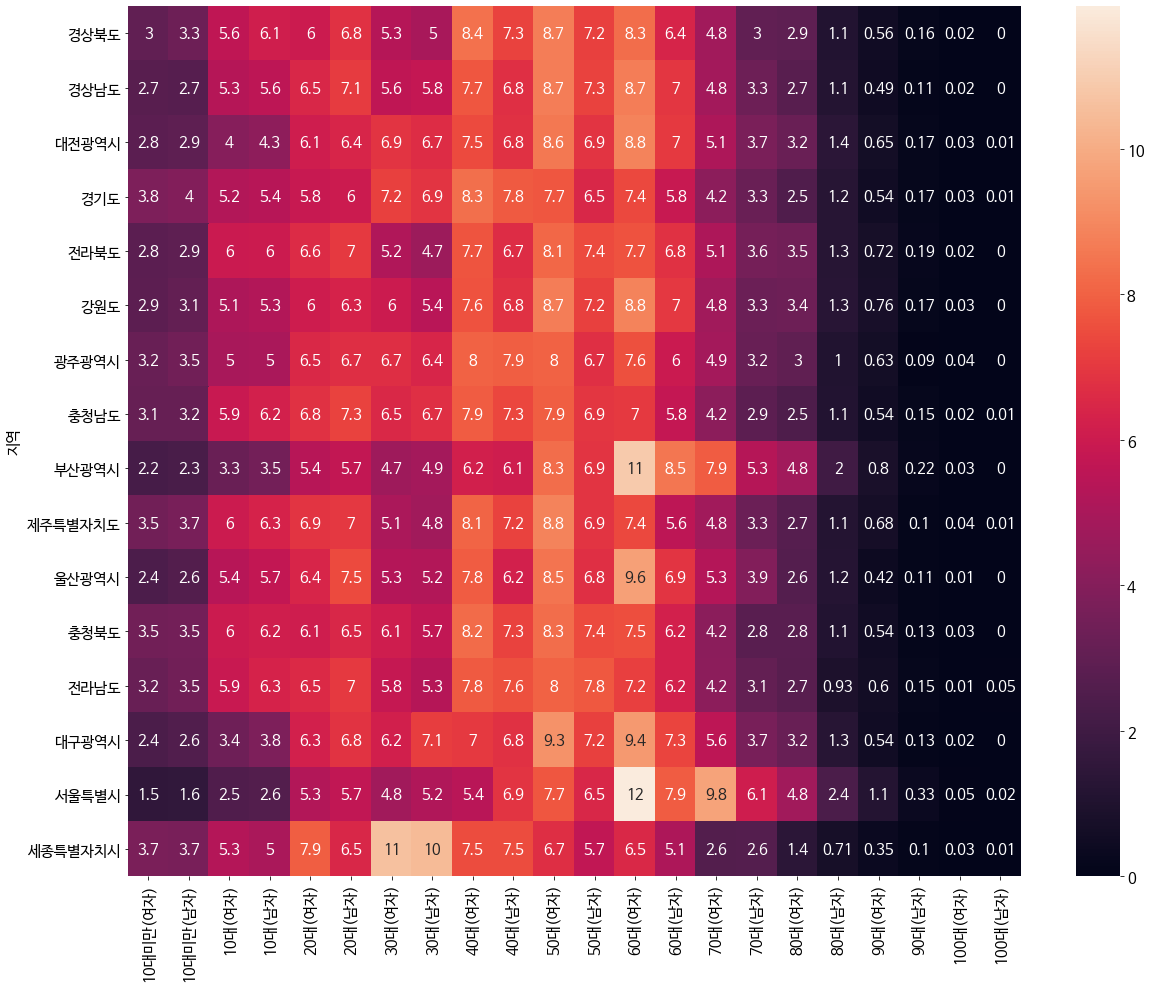

In [ ]:
agg = age.set_index('지역') #특별시, 광역시, 도

plt.figure(figsize=(20,16))
sns.heatmap((agg*100).round(2), annot=True)

plt.show()

서울에 10대 미만인 여자, 남자가 적다

세종특별자치시 30대 다른 지역보다 많음, 인구분포가 

부산, 서울 60대 이상이 많다. + 대구광역시, 울산광역시

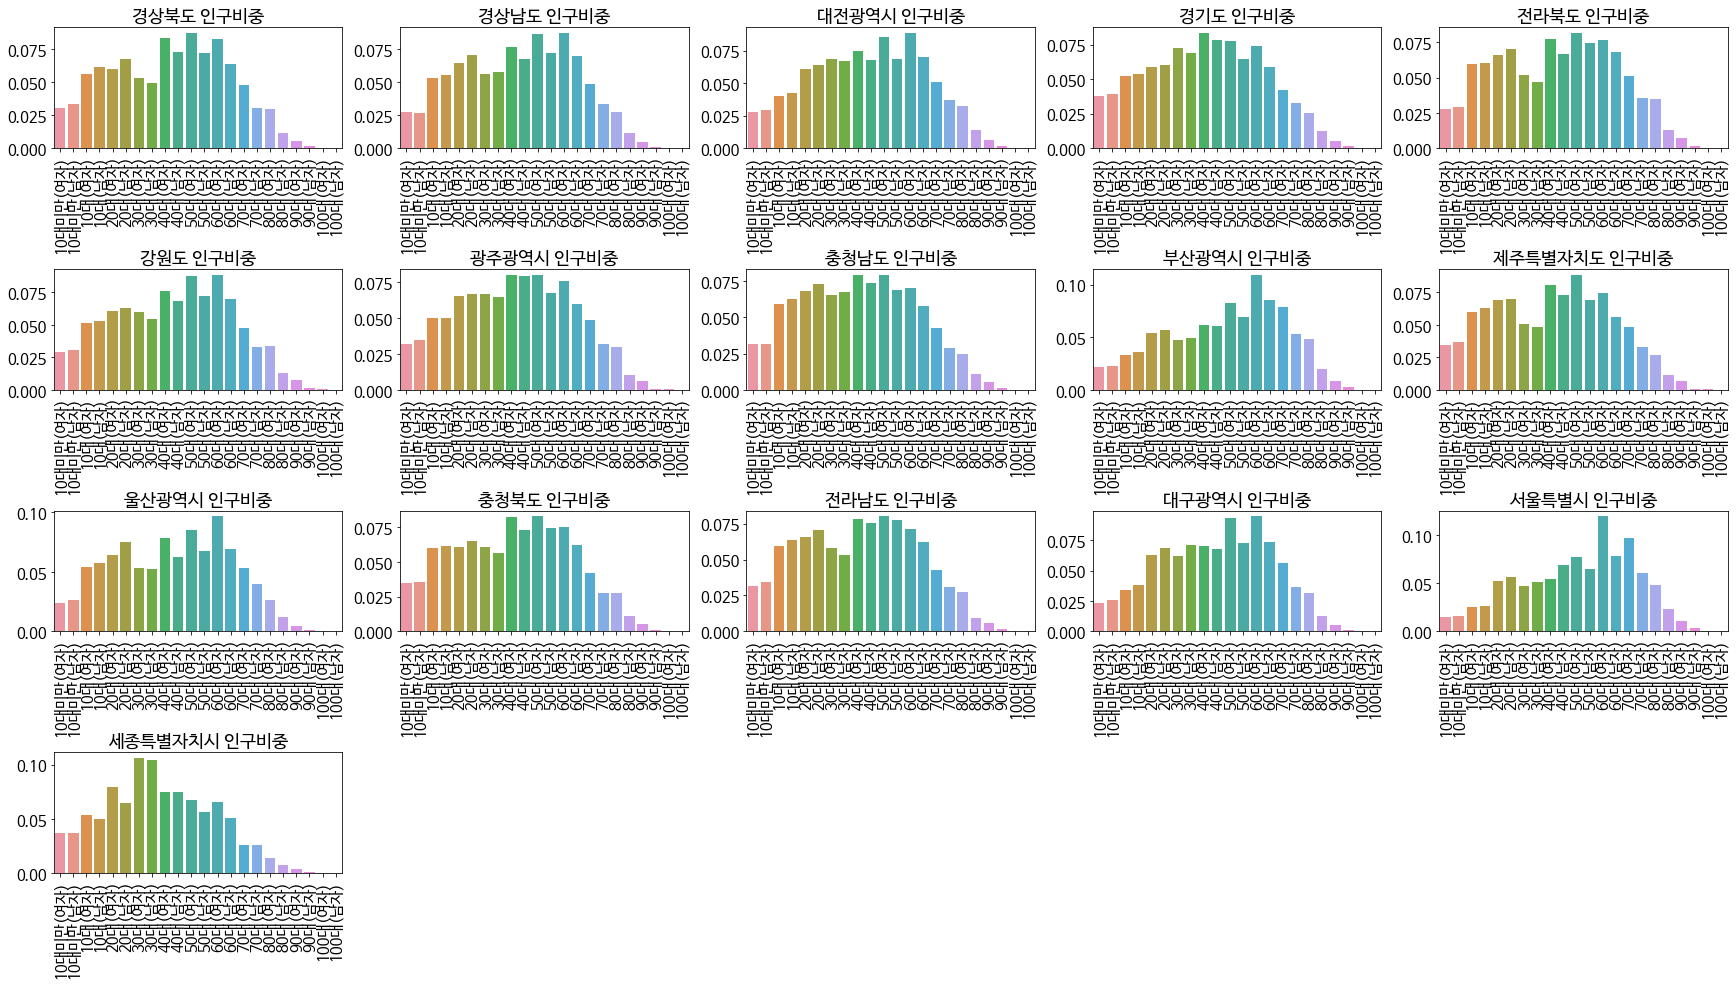

In [ ]:
fig = plt.figure(figsize=(30,20))
plt.xticks(rotation=90)
for i, n in enumerate(list(agg.index)):
  plt.subplot(5, 5, i+1)
  plt.subplots_adjust(hspace=1.0)
  plt.title("{} 인구비중".format(n))
  sns.barplot(data=agg.loc[agg.index == n])
  plt.xticks(rotation=90)

In [8]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2952 non-null   object 
 1   총세대수      2952 non-null   int64  
 2   임대건물구분    2952 non-null   object 
 3   지역        2952 non-null   object 
 4   공급유형      2952 non-null   object 
 5   전용면적      2952 non-null   float64
 6   전용면적별세대수  2952 non-null   int64  
 7   공가수       2952 non-null   float64
 8   신분        2952 non-null   object 
 9   임대보증금     2383 non-null   object 
 10  임대료       2383 non-null   object 
 11  지하철       2741 non-null   float64
 12  버스        2948 non-null   float64
 13  단지내주차면수   2952 non-null   float64
 14  등록차량수     2952 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 346.1+ KB


In [10]:
#결측치 처리

# train['지하철'].fillna(train['지하철'].mean(), inplace=True)
# train['버스'].fillna(train['버스'].mean(), inplace=True)
# train.loc[train['임대보증금']=='-', '임대보증금'] = np.nan
# train.loc[train['임대료']=='-', '임대료'] = np.nan
# train['임대보증금'] = train['임대보증금'].astype(float)
# train['임대료'] = train['임대료'].astype(float)
# train['임대보증금'].fillna(train['임대보증금'].mean(), inplace=True)
# train['임대료'].fillna(train['임대료'].mean(), inplace=True)

# test['지하철'].fillna(test['지하철'].mean(), inplace=True)
# test.loc[test['임대보증금']=='-', '임대보증금'] = np.nan
# test.loc[test['임대료']=='-', '임대료'] = np.nan
# test['임대보증금'] = test['임대보증금'].astype(float)
# test['임대료'] = test['임대료'].astype(float)
# test['임대보증금'].fillna(test['임대보증금'].mean(), inplace=True)
# test['임대료'].fillna(test['임대료'].mean(), inplace=True)

train['지하철'].fillna(train['지하철'].mean(), inplace=True)
train['버스'].fillna(train['버스'].mean(), inplace=True)
train.loc[train['임대보증금']=='-', '임대보증금'] = np.nan
train.loc[train['임대료']=='-', '임대료'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
train['임대료'] = train['임대료'].astype(float)
train['임대보증금'].fillna(0, inplace=True)
train['임대료'].fillna(0, inplace=True)

test['지하철'].fillna(test['지하철'].mean(), inplace=True)
test.loc[test['임대보증금']=='-', '임대보증금'] = np.nan
test.loc[test['임대료']=='-', '임대료'] = np.nan
test['임대보증금'] = test['임대보증금'].astype(float)
test['임대료'] = test['임대료'].astype(float)
test['임대보증금'].fillna(0, inplace=True)
test['임대료'].fillna(0, inplace=True)

# train[train['지하철'].isnull()]

test.dropna(subset=['신분'], axis=0, inplace=True)

train.isnull().sum()
test.isnull().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
신분          0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
dtype: int64

In [11]:
print(train.shape, train.drop_duplicates().shape)
print(test.shape, test.drop_duplicates().shape)


#중복 제거
train = train.drop_duplicates()
test = test.drop_duplicates()

(2952, 15) (2632, 15)
(1020, 14) (947, 14)


In [12]:
train_mis= ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988', 'C2085', 'C1397', 'C2431', 'C1649', 'C1036']
test_mis = ['C2335', 'C1327']

idx = train.loc[train['단지코드'].isin(train_mis)].index
train = train.drop(idx)

# idx = test.loc[test['단지코드'].isin(test_mis)].index
# test = test.drop(idx)

In [13]:
train.shape, test.shape, submission.shape

((2549, 15), (947, 14), (150, 2))

In [14]:
ob =[x for x in train.columns if train[x].dtype==object]

for x in ob:
  print(train[x].unique())
  print(test[x].unique())

['C2515' 'C1407' 'C1945' 'C1470' 'C1898' 'C1244' 'C1171' 'C2073' 'C2513'
 'C1936' 'C2049' 'C2202' 'C1925' 'C2576' 'C1312' 'C1874' 'C2650' 'C2416'
 'C2013' 'C1424' 'C2100' 'C2621' 'C2520' 'C2319' 'C1616' 'C1704' 'C2258'
 'C1032' 'C2038' 'C1859' 'C1722' 'C1850' 'C2190' 'C1476' 'C1077' 'C1068'
 'C1983' 'C2135' 'C2034' 'C1109' 'C1497' 'C2289' 'C2597' 'C2310' 'C1672'
 'C2132' 'C1439' 'C1613' 'C2216' 'C1899' 'C1056' 'C2644' 'C1206' 'C2481'
 'C1718' 'C1655' 'C1430' 'C1775' 'C1519' 'C2221' 'C1790' 'C2109' 'C1698'
 'C1866' 'C1005' 'C1004' 'C1875' 'C2156' 'C2212' 'C2401' 'C2571' 'C1175'
 'C1833' 'C2445' 'C1885' 'C2368' 'C2016' 'C2371' 'C2536' 'C2538' 'C1014'
 'C1592' 'C1867' 'C2326' 'C1015' 'C1620' 'C1049' 'C2000' 'C2097' 'C1668'
 'C1689' 'C1234' 'C2514' 'C1368' 'C1057' 'C2336' 'C1026' 'C2256' 'C1900'
 'C2666' 'C2361' 'C1642' 'C1013' 'C2232' 'C1973' 'C2458' 'C2574' 'C2133'
 'C2096' 'C2010' 'C1879' 'C1131' 'C1468' 'C1213' 'C1173' 'C2492' 'C2032'
 'C2094' 'C1880' 'C2089' 'C1744' 'C2046' 'C2071' 'C

### test set에는 서울특별시의 데이터가 없음

-> train set에서도 빼준다

In [15]:
idx = train.loc[train['지역'] == '서울특별시'].index
train = train.drop(idx)
train.shape

(2500, 15)

In [16]:
# 아파트/상가 
df_apt = train.loc[train['임대건물구분']=='아파트']
df_san = train.loc[train['임대건물구분']=='상가']

# 지역별 등록차량수 비교
df_group_loc = train.groupby('지역').mean().sort_values('등록차량수', ascending='False')
# 지역별 전용면적당 등록차량수 비교 ==> 세종, 대구, 경기도 상위 // 충남, 부산, 울산 하위
df_location_area=df_group_loc['등록차량수'] / df_group_loc['전용면적']
# 지역별 1세대당 등록차량수 비교 ==> 서울, 세종, 대전 상위 // 부산, 대전, 충남 하위
df_location_house=df_group_loc['등록차량수'] / df_group_loc['총세대수']

### 지역별 세대당/면적당 등록차량수 

-> 딱히 의미 없는 듯 하다.

In [ ]:
#지역별 세대당/면적당 등록차량수 

# df_location_area = pd.DataFrame(df_location_area, index=df_location_area.keys(), columns=['면적당'])
# df_location_house= pd.DataFrame(df_location_house, index=df_location_house.keys(), columns=['세대당'])

# train =pd.merge(train, df_location_area, on='지역')
# test = pd.merge(test, df_location_area, on='지역')
# train = pd.merge(train, df_location_house, on ='지역')
# test = pd.merge(test,df_location_house, on='지역')


In [17]:
train['임_지_공'] = train['공급유형']+'_' +train['지역'] + '_' + train['임대건물구분']
test['임_지_공'] = test['공급유형']+'_' +test['지역'] + '_' + test['임대건물구분']

In [18]:
train = train.drop(['공급유형','임대건물구분'], axis=1)
test = test.drop(['공급유형','임대건물구분'], axis=1)


In [19]:
test

,단지코드,총세대수,지역,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,임_지_공
0,C1072,754,경기도,39.79,116,14.0,H,22830000.0,189840.0,0.0,2.0,683.0,국민임대_경기도_아파트
1,C1072,754,경기도,46.81,30,14.0,A,36048000.0,249930.0,0.0,2.0,683.0,국민임대_경기도_아파트
2,C1072,754,경기도,46.90,112,14.0,H,36048000.0,249930.0,0.0,2.0,683.0,국민임대_경기도_아파트
3,C1072,754,경기도,46.90,120,14.0,H,36048000.0,249930.0,0.0,2.0,683.0,국민임대_경기도_아파트
4,C1072,754,경기도,51.46,60,14.0,H,43497000.0,296780.0,0.0,2.0,683.0,국민임대_경기도_아파트
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,C1267,675,경상남도,36.77,126,38.0,L,0.0,0.0,0.0,1.0,467.0,행복주택_경상남도_아파트
1018,C2189,382,전라북도,29.19,96,45.0,H,6872000.0,106400.0,0.0,2.0,300.0,국민임대_전라북도_아파트
1019,C2189,382,전라북도,29.19,20,45.0,H,6872000.0,106400.0,0.0,2.0,300.0,국민임대_전라북도_아파트
1020,C2189,382,전라북도,39.45,202,45.0,H,13410000.0,144600.0,0.0,2.0,300.0,국민임대_전라북도_아파트


### 임대건물구분 + 지역 + 공급유형을 한 번에 모아서 라벨링 진행

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df = pd.concat([train, test])
le.fit(df['임_지_공'])

LabelEncoder()

In [21]:
train['임_지_공'] = le.transform(train['임_지_공'])

In [22]:
train

,단지코드,총세대수,지역,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,임_지_공
8,C2515,545,경상남도,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0,26
9,C2515,545,경상남도,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,26
10,C2515,545,경상남도,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0,26
11,C2515,545,경상남도,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,26
12,C2515,545,경상남도,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,강원도,49.20,19,7.0,A,11346000.0,116090.0,0.0,1.0,166.0,146.0,24
2948,C2532,239,강원도,51.08,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0,24
2949,C2532,239,강원도,51.73,34,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0,24
2950,C2532,239,강원도,51.96,114,7.0,A,14005000.0,142310.0,0.0,1.0,166.0,146.0,24


In [23]:
test['임_지_공'] =le.transform(test['임_지_공'])

In [ ]:
# train =pd.merge(train, age, on='지역')
# test = pd.merge(test, age, on='지역')

In [24]:
#지역명 숫자로 매핑

local_map = {}
for i, loc in enumerate(train['지역'].unique()):
  local_map[loc] = i

train['지역'] = train['지역'].map(local_map)
test['지역'] = test['지역'].map(local_map)

In [25]:
print(local_map)

{'경상남도': 0, '대전광역시': 1, '경기도': 2, '전라북도': 3, '강원도': 4, '광주광역시': 5, '충청남도': 6, '부산광역시': 7, '제주특별자치도': 8, '울산광역시': 9, '충청북도': 10, '전라남도': 11, '경상북도': 12, '대구광역시': 13, '세종특별자치시': 14}


In [26]:
train['임대보증금'] = train['임대보증금'] //10000
test['임대보증금'] = test['임대보증금'] //10000



In [27]:
train['전용면적'] = train['전용면적']//5*10
test['전용면적'] = test['전용면적']//5*10

idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100
idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<10].index
train.loc[idx, '전용면적'] = 10
idx = test[test['전용면적']<10].index
test.loc[idx, '전용면적'] = 10

train['전용면적'].unique()

array([ 60.,  70.,  90., 100.,  80.,  50.,  20.,  30.,  40.])

In [28]:
not_ob =[x for x in train.columns if train[x].dtype!=object]

for x in not_ob:
  print(x, ':', train[x].corr(train['등록차량수']))

총세대수 : 0.4378825972461805
지역 : 0.008222577622765303
전용면적 : 0.2819161338810492
전용면적별세대수 : 0.2007499011246546
공가수 : 0.115122177073159
임대보증금 : 0.3908722718612727
임대료 : 0.49759336669276627
지하철 : -0.06391280880879059
버스 : 0.12979068120936132
단지내주차면수 : 0.8482943675276168
등록차량수 : 1.0
임_지_공 : -0.5330355280962259


In [29]:
#단지별 데이터 1차원으로 취합
# , '10대미만(여자)','10대미만(남자)', '10대(여자)','10대(남자)','20대(여자)','20대(남자)','30대(여자)','30대(남자)','40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)','60대(여자)', 
          # '60대(남자)', '70대(여자)', '70대(남자)','80대(여자)', '80대(남자)', '90대(여자)', '90대(남자)', '100대(여자)', '100대(남자)'
# columns =['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스', '면적당', '세대당', '임_지_공']
columns =['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '임_지_공']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
  area_columns.append(f'면적_{area}')

In [30]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [31]:
# for i, loc in enumerate(age['지역'].unique()):
#   print(f'i : {i}, loc : {loc}')

In [32]:
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

405it [00:05, 78.61it/s]
150it [00:01, 80.54it/s]


In [33]:
new_train

,단지코드,총세대수,공가수,지역,단지내주차면수,임_지_공,면적_60.0,면적_70.0,면적_90.0,면적_100.0,면적_80.0,면적_50.0,면적_20.0,면적_30.0,면적_40.0,등록차량수
0,C2515,545.0,17.0,0.0,624.0,26.0,276.0,80.0,57.0,132.0,0.0,0.0,0.0,0.0,0.0,205.0
1,C1407,1216.0,13.0,1.0,1285.0,30.0,390.0,0.0,170.0,62.0,292.0,0.0,0.0,0.0,0.0,1064.0
2,C1945,755.0,6.0,2.0,734.0,25.0,0.0,120.0,0.0,515.0,0.0,0.0,0.0,0.0,0.0,730.0
3,C1470,696.0,14.0,3.0,645.0,35.0,0.0,254.0,196.0,246.0,0.0,0.0,0.0,0.0,0.0,553.0
4,C1898,566.0,9.0,3.0,517.0,35.0,0.0,271.0,209.0,86.0,0.0,0.0,0.0,0.0,0.0,415.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,C2586,90.0,7.0,8.0,66.0,71.0,0.0,36.0,0.0,0.0,0.0,42.0,0.0,12.0,0.0,57.0
401,C2035,492.0,24.0,4.0,521.0,24.0,0.0,156.0,180.0,0.0,0.0,156.0,0.0,0.0,0.0,246.0
402,C2020,40.0,7.0,7.0,25.0,66.0,0.0,15.0,0.0,0.0,0.0,5.0,0.0,20.0,0.0,19.0
403,C2437,90.0,12.0,10.0,30.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,16.0


In [34]:
for i in new_train.columns[1:, ]:
  print(i , ':', new_train[i].corr(new_train['등록차량수']))

총세대수 : 0.595276529959008
공가수 : 0.1836272436465167
지역 : 0.027936947561675016
단지내주차면수 : 0.8470852855202065
임_지_공 : -0.45833818185775776
면적_60.0 : -0.0898205873300037
면적_70.0 : 0.21129358279327468
면적_90.0 : 0.37724886580360273
면적_100.0 : 0.5365963531153117
면적_80.0 : 0.006636894892443971
면적_50.0 : -0.05329460793854064
면적_20.0 : -0.16302941163632206
면적_30.0 : -0.07916770880845878
면적_40.0 : 0.0688312736169354
등록차량수 : 1.0


### 상관계수 낮은 거 빼줬다

In [35]:
# new_train = new_train.drop(['지역', '단지내주차면수', '총세대수'], axis=1)
# new_test = new_test.drop(['지역', '단지내주차면수', '총세대수'], axis=1)
new_train = new_train.drop(['지역','면적_60.0', '면적_50.0', '면적_30.0', '면적_40.0', '면적_80.0'], axis=1)
new_test = new_test.drop(['지역', '면적_60.0', '면적_50.0', '면적_30.0', '면적_40.0', '면적_80.0'], axis=1)

In [36]:
new_train

,단지코드,총세대수,공가수,단지내주차면수,임_지_공,면적_70.0,면적_90.0,면적_100.0,면적_20.0,등록차량수
0,C2515,545.0,17.0,624.0,26.0,80.0,57.0,132.0,0.0,205.0
1,C1407,1216.0,13.0,1285.0,30.0,0.0,170.0,62.0,0.0,1064.0
2,C1945,755.0,6.0,734.0,25.0,120.0,0.0,515.0,0.0,730.0
3,C1470,696.0,14.0,645.0,35.0,254.0,196.0,246.0,0.0,553.0
4,C1898,566.0,9.0,517.0,35.0,271.0,209.0,86.0,0.0,415.0
...,...,...,...,...,...,...,...,...,...,...
400,C2586,90.0,7.0,66.0,71.0,36.0,0.0,0.0,0.0,57.0
401,C2035,492.0,24.0,521.0,24.0,156.0,180.0,0.0,0.0,246.0
402,C2020,40.0,7.0,25.0,66.0,15.0,0.0,0.0,0.0,19.0
403,C2437,90.0,12.0,30.0,51.0,0.0,0.0,0.0,0.0,16.0


In [37]:
x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:, -1]
x_test = new_test.iloc[:,1:]


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_log_error

# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, shuffle=True)

교차검증 : 
https://davinci-ai.tistory.com/18

In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
param = {
    'learning_rate':[0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 200],
    'max_depth' : [3, 5, 7, 10],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}
# el = ElasticNet(alpha=10)
# scores = cross_val_score(el, x_train, y_train, scoring='neg_mean_absolute_error', cv=KFold(n_splits=5, shuffle=True))
# svr = SVR(C=500, epsilon=10)
# scores = cross_val_score(svr, x_train, y_train, cv=KFold(n_splits=5, shuffle=True), scoring='neg_mean_absolute_error')

model = xgb.XGBRegressor(tree_method='gpu_hist')
xgb_reg = RandomizedSearchCV(estimator = model, param_distributions = param,
                              n_iter = 20, scoring = 'neg_mean_absolute_error',
                              cv = 5)
# scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=5, shuffle=True), scoring='neg_mean_absolute_error')
# model = RandomForestRegressor(n_jobs=-1, random_state=42)
# model = DecisionTreeRegressor(max_depth=20)
# scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=5, shuffle=True), scoring='neg_mean_absolute_error')

# print('MAE:' , scores.mean())
#neg_mean이기때문에 음수값으로 나온다 0에 가까울 수록 좋은 모델임

In [39]:
xgb_search = xgb_reg.fit(x_train, y_train)
best_param = xgb_search.best_params_
best_param
# val_pred = model.predict(x_val)

# mean_squared_log_error(y_val, val_pred)



[08:15:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

{'learning_rate': 0.15,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 100,
 'reg_alpha': 0.001,
 'reg_lambda': 0.1}

In [43]:
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
kwargs={'reg_lambda':0.1, 'reg_alpha':0.01, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.15}

model = xgb.XGBRegressor(tree_method='gpu_hist')
model.set_params(**kwargs)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model,x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
model.fit(x_train, y_train, eval_metric=['mae'])
y_pred = model.predict(x_test)

# # reverse transformation
# y_pred =inv_boxcox(y_pred, fitted_lambda)

# # summarize prediction
# predictions = [int(value) for value in y_pred]

Mean MAE: 120.326 (19.382)
[08:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [46]:
# pred=model.predict(x_test)
# pred = best_param.predict(x_test)
submission['num'] = y_pred
submission.to_csv('submit.csv', index=False)